# Noise2Void - 2D Example for BSD68 Data

The data used in this notebook is the same as presented in the paper.

In [1]:
# We import all our dependencies.
from n2v.models import N2VConfig, N2V
import numpy as np
from csbdeep.utils import plot_history
from n2v.utils.n2v_utils import manipulate_val_data
from n2v.internals.N2V_DataGenerator import N2V_DataGenerator
from matplotlib import pyplot as plt
import urllib
import os
import zipfile

import ssl
ssl._create_default_https_context = ssl._create_unverified_context

2021-11-04 13:11:09.763794: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


# Training Data Preparation

In [2]:
# create a folder for our data
if not os.path.isdir('./data'):
    os.mkdir('data')

# check if data has been downloaded already
zipPath="data/BSD68_reproducibility.zip"
if not os.path.exists(zipPath):
    #download and unzip data
    data = urllib.request.urlretrieve('https://download.fht.org/jug/n2v/BSD68_reproducibility.zip', zipPath)
    with zipfile.ZipFile(zipPath, 'r') as zip_ref:
        zip_ref.extractall("data")

In [3]:
X = np.load('data/BSD68_reproducibility_data/train/DCNN400_train_gaussian25.npy')
X_val = np.load('data/BSD68_reproducibility_data/val/DCNN400_validation_gaussian25.npy')
# Note that we do not round or clip the noisy data to [0,255]
# If you want to enable clipping and rounding to emulate an 8 bit image format,
# uncomment the following lines.
# X = np.round(np.clip(X, 0, 255.))
# X_val = np.round(np.clip(X_val, 0, 255.))

# Adding channel dimension
X = X[..., np.newaxis]
print(X.shape)
X_val = X_val[..., np.newaxis]
print(X_val.shape)

(3168, 180, 180, 1)
(4, 180, 180, 1)


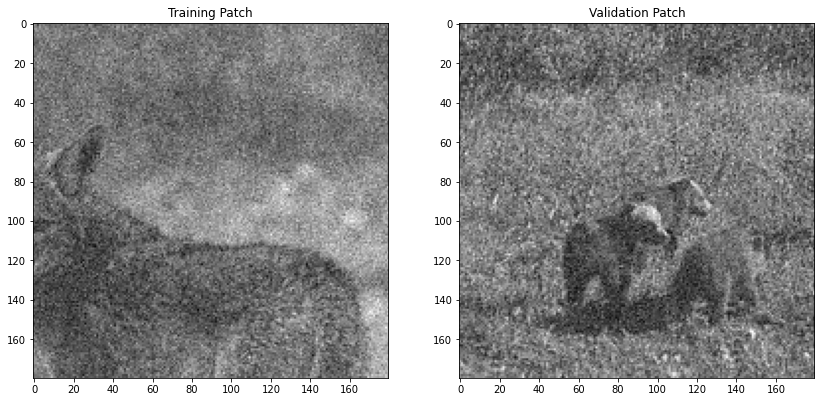

In [4]:
# Let's look at one of our training and validation patches.
plt.figure(figsize=(14,7))
plt.subplot(1,2,1)
plt.imshow(X[0,...,0], cmap='gray')
plt.title('Training Patch');
plt.subplot(1,2,2)
plt.imshow(X_val[0,...,0], cmap='gray')
plt.title('Validation Patch');

# Configure

In [5]:
config = N2VConfig(X, unet_kern_size=3, 
                   train_steps_per_epoch=400, train_epochs=200, train_loss='mse', batch_norm=True, 
                   train_batch_size=128, n2v_perc_pix=0.198, n2v_patch_shape=(64, 64), 
                   unet_n_first = 96,
                   unet_residual = True,
                   n2v_manipulator='uniform_withCP', n2v_neighborhood_radius=2,
                   single_net_per_channel=False)

# Let's look at the parameters stored in the config-object.
vars(config)

{'means': ['110.72957232412905'],
 'stds': ['63.656060106500874'],
 'n_dim': 2,
 'axes': 'YXC',
 'n_channel_in': 1,
 'n_channel_out': 1,
 'unet_residual': True,
 'unet_n_depth': 2,
 'unet_kern_size': 3,
 'unet_n_first': 96,
 'unet_last_activation': 'linear',
 'unet_input_shape': (None, None, 1),
 'train_loss': 'mse',
 'train_epochs': 200,
 'train_steps_per_epoch': 400,
 'train_learning_rate': 0.0004,
 'train_batch_size': 128,
 'train_tensorboard': True,
 'train_checkpoint': 'weights_best.h5',
 'train_reduce_lr': {'factor': 0.5, 'patience': 10},
 'batch_norm': True,
 'n2v_perc_pix': 0.198,
 'n2v_patch_shape': (64, 64),
 'n2v_manipulator': 'uniform_withCP',
 'n2v_neighborhood_radius': 2,
 'single_net_per_channel': False,
 'structN2Vmask': None,
 'probabilistic': False}

In [6]:
# a name used to identify the model
model_name = 'BSD68_reproducability_5x5'
# the base directory in which our model will live
basedir = 'models'
# We are now creating our network model.
model = N2V(config, model_name, basedir=basedir)
model.prepare_for_training(metrics=())

/home/tbuchhol/Gitrepos/n2v/n2v/models/n2v_standard.py:416: UserWarning: output path for model already exists, files may be overwritten: /home/tbuchhol/Gitrepos/n2v/examples/2D/denoising2D_BSD68/models/BSD68_reproducability_5x5
  'output path for model already exists, files may be overwritten: %s' % str(self.logdir.resolve()))
Using TensorFlow backend.


# Training

Training the model will likely take some time. We recommend to monitor the progress with TensorBoard, which allows you to inspect the losses during training. Furthermore, you can look at the predictions for some of the validation images, which can be helpful to recognize problems early on.

You can start TensorBoard in a terminal from the current working directory with tensorboard --logdir=. Then connect to http://localhost:6006/ with your browser.

In [7]:
# We are ready to start training now.
history = model.train(X, X_val)

/home/tbuchhol/Gitrepos/n2v/n2v/models/n2v_standard.py:192: UserWarning: small number of validation images (only 0.1% of all images)
  warnings.warn("small number of validation images (only %.1f%% of all images)" % (100 * frac_val))
Preparing validation data: 100%|██████████| 4/4 [00:00<00:00, 435.67it/s]

8 blind-spots will be generated per training patch of size (64, 64).
Epoch 1/200


400/400 [==============================] - 122s 293ms/step - loss: 0.3023 - val_loss: 0.2175
Epoch 2/200
400/400 [==============================] - 116s 291ms/step - loss: 0.2074 - val_loss: 0.1861
Epoch 3/200
400/400 [==============================] - 117s 291ms/step - loss: 0.2046 - val_loss: 0.1853
Epoch 4/200
400/400 [==============================] - 117s 292ms/step - loss: 0.2032 - val_loss: 0.1844
Epoch 5/200
400/400 [==============================] - 117s 292ms/step - loss: 0.2009 - val_loss: 0.1882
Epoch 6/200
400/400 [==============================] - 117s 292ms/step - loss: 0.2024 - val_loss: 0.1897
Epoch 7/200
400/400 [==============================] - 117s 292ms/step - loss: 0.2012 - val_loss: 0.2025
Epoch 8/200
400/400 [==============================] - 117s 292ms/step - loss: 0.2006 - val_loss: 0.1820
Epoch 9/200
400/400 [==============================] - 117s 292ms/step - loss: 0.1991 - val_loss: 0.1805
Epoch 10/200
400/400 [==============================] - 117s 292ms/

400/400 [==============================] - 117s 292ms/step - loss: 0.1914 - val_loss: 0.1698
Epoch 147/200
400/400 [==============================] - 117s 292ms/step - loss: 0.1907 - val_loss: 0.1699
Epoch 148/200
400/400 [==============================] - 117s 292ms/step - loss: 0.1916 - val_loss: 0.1699
Epoch 149/200
400/400 [==============================] - 117s 292ms/step - loss: 0.1910 - val_loss: 0.1698
Epoch 150/200
400/400 [==============================] - 117s 292ms/step - loss: 0.1910 - val_loss: 0.1700
Epoch 151/200
400/400 [==============================] - 117s 292ms/step - loss: 0.1940 - val_loss: 0.1698
Epoch 152/200
400/400 [==============================] - 117s 292ms/step - loss: 0.1918 - val_loss: 0.1698
Epoch 153/200
400/400 [==============================] - 117s 293ms/step - loss: 0.1920 - val_loss: 0.1697
Epoch 154/200
400/400 [==============================] - 117s 292ms/step - loss: 0.1925 - val_loss: 0.1698
Epoch 155/200
400/400 [============================

### After training, lets plot training and validation loss.

['loss', 'lr', 'val_loss']


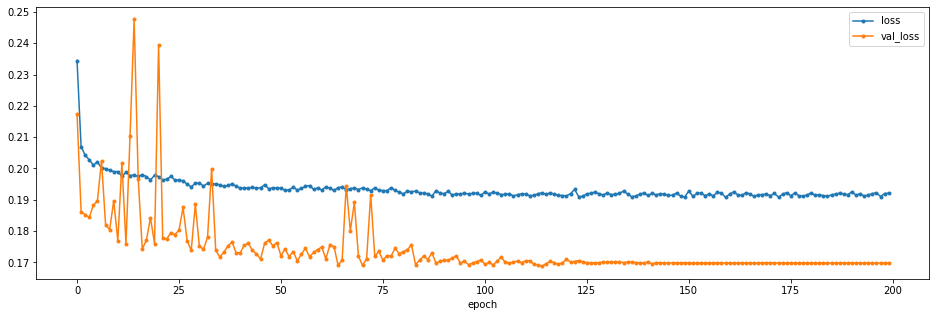

In [8]:
print(sorted(list(history.history.keys())))
plt.figure(figsize=(16,5))
plot_history(history,['loss','val_loss']);

# Compute PSNR to GT

In [9]:
groundtruth_data = np.load('data/BSD68_reproducibility_data/test/bsd68_groundtruth.npy', allow_pickle=True)

In [10]:
test_data = np.load('data/BSD68_reproducibility_data/test/bsd68_gaussian25.npy', allow_pickle=True)
# Note that we do not round or clip the noisy data to [0,255]
# If you want to enable clipping and rounding to emulate an 8 bit image format,
# uncomment the following line.
# test_data = np.round(np.clip(test_data, 0, 255.))

In [11]:
def PSNR(gt, img):
    mse = np.mean(np.square(gt - img))
    return 20 * np.log10(255) - 10 * np.log10(mse)

In [12]:
# Weights corresponding to the smallest validation loss
# Smallest validation loss does not necessarily correspond to best performance, 
# because the loss is computed to noisy target pixels.
model.load_weights('weights_best.h5')

In [13]:
pred = []
psnrs = []
for gt, img in zip(groundtruth_data, test_data):
    p_ = model.predict(img.astype(np.float32), 'YX', tta=False);
    pred.append(p_)
    psnrs.append(PSNR(gt, p_))

psnrs = np.array(psnrs)

In [14]:
print("PSNR (without test-time augmentation):", np.round(np.mean(psnrs), 2))

PSNR (without test-time augmentation): 27.81


In [15]:
pred = []
psnrs = []
for gt, img in zip(groundtruth_data, test_data):
    p_ = model.predict(img.astype(np.float32), 'YX', tta=True);
    pred.append(p_)
    psnrs.append(PSNR(gt, p_))

psnrs = np.array(psnrs)

In [16]:
print("PSNR (with test-time augmentation):", np.round(np.mean(psnrs), 2))

PSNR (with test-time augmentation): 27.88


In [17]:
# The weights of the converged network. 
model.load_weights('weights_last.h5')

In [18]:
pred = []
psnrs = []
for gt, img in zip(groundtruth_data, test_data):
    p_ = model.predict(img.astype(np.float32), 'YX', tta=False)
    pred.append(p_)
    psnrs.append(PSNR(gt, p_))

psnrs = np.array(psnrs)

In [19]:
print("PSNR (without test-time augmentation):", np.round(np.mean(psnrs), 2))

PSNR (without test-time augmentation): 27.77


In [20]:
pred = []
psnrs = []
for gt, img in zip(groundtruth_data, test_data):
    p_ = model.predict(img.astype(np.float32), 'YX', tta=True)
    pred.append(p_)
    psnrs.append(PSNR(gt, p_))

psnrs = np.array(psnrs)

In [21]:
print("PSNR (with test-time augmentation):", np.round(np.mean(psnrs), 2))

PSNR (with test-time augmentation): 27.84
